# Session Based Datasets

when running `run_example/session_based_rec_example.py` we see it supports only 3 datasets : `tmall-session`, `diginetica-session` and `nowplaying-session` 
however, when looking at [RecBole Dataset List](https://recbole.io/dataset_list.html) we see many more datasets.  
moreover, it looks like the `-session` based versions are different than the files downloaded from the [Google Drive](https://drive.google.com/drive/folders/1so0lckI6N6_niVEYaBu-LIcpOdZf99kj?usp=sharing)  

in this notebook I'll try to explore the various datasets to understand what do we have in it

I'll follow the example to download the datasets

In [1]:
import os 
import pandas as pd
import numpy as np
from datetime import datetime
from recbole.config import Config
from recbole.data import create_dataset
from recbole.data.utils import get_dataloader
from recbole.utils import init_logger, init_seed, get_model, get_trainer, set_color

In [2]:
from dataclasses import dataclass

@dataclass
class Arguments:
    model:str = 'GRU4Rec'
    dataset:str = 'diginetica-session'
    validation: bool = 'False'
    valid_portion: float = 0.1

args=Arguments()


## DIGINETICA
there are 2 versions : the `diginetica-session` and the `diginetica` 

### diginetica-session

In [ ]:
args=Arguments()
args

In [ ]:
config_dict = {
    'USER_ID_FIELD': 'session_id',
    'load_col': None,
    'neg_sampling': None,
    'benchmark_filename': ['train', 'test'],
    'alias_of_item_id': ['item_id_list'],
    'topk': [20],
    'metrics': ['Recall', 'MRR'],
    'valid_metric': 'MRR@20'
}

In [ ]:
config = Config(model=args.model, dataset=f'{args.dataset}', config_dict=config_dict)
config.final_config_dict

In [ ]:
config.final_config_dict['data_path'] = os.path.join(os.path.dirname(os.getcwd()),config.final_config_dict['data_path'])
config.final_config_dict['data_path']

In [ ]:
digi_sess = create_dataset(config)
digi_sess

In [ ]:
digi_sess

In [ ]:
# the main interaction data is in the inter_feat data frame:
digi_sess_df = digi_sess.inter_feat
digi_sess_df.head(30)


In [ ]:
digi_sess_df.session_id.value_counts()

In [ ]:
digi_sess_df.item_id.value_counts()

In [ ]:
digi_sess_df.item_id.max()

### diginetica

In [ ]:
digi_args = Arguments(dataset='diginetica')
digi_args

In [ ]:
digi_config_dict= {
        'USER_ID_FIELD': 'session_id',
        'load_col': None,       # load all columns. dont filter anything
        'neg_sampling': None,
        # 'benchmark_filename': ['train', 'test'],
        # 'alias_of_item_id': ['item_id_list'],
        'eval_args':{
            'group_by': 'user',
            'order': 'TO',
            'split':{'LS': 'test_only'},
            'mode': 'uni100'},
        'topk': [20],
        'metrics': ['Recall', 'MRR'],
        'valid_metric': 'MRR@20'
    }


In [ ]:
digi_config = Config(model=digi_args.model, dataset=f'{digi_args.dataset}', config_dict=digi_config_dict)
digi_config.final_config_dict

In [ ]:
digi_config.final_config_dict['data_path'] = os.path.join(os.path.dirname(os.getcwd()),digi_config.final_config_dict['data_path'])
digi_config.final_config_dict['data_path']

In [ ]:
diginetica = create_dataset(digi_config)
diginetica

In [ ]:
digi_df=diginetica.inter_feat
digi_df.head()

In [ ]:
digi_df.item_id.max()

In [ ]:
digi_df.item_id.value_counts()

### compare

In [ ]:
# diginetica.inter_feat.session_id.value_counts()
print(len(diginetica))
print(len(digi_sess))

In [ ]:
digi_sess

In [ ]:
print(len(digi_sess.inter_feat.session_id.unique()))
digi_sess.inter_feat.head()

In [ ]:
print(len(diginetica.inter_feat.session_id.unique()))
diginetica.inter_feat.head()

In [ ]:
len(diginetica.inter_feat.session_id)

when looking at the datasets summaries we see the following :
![img](SBRS_datasets.jpg)

only in the number of items I see some similarity between the table and the `diginetica-session`. it looks like diginetica is not a session based dataset but was made such using some "session-ization" process

Lets check how the dataset from `session-rec` looks like:

### session-rec
the datasets (according to the paper) are:  
![img2](empirical_sbrs_datasets.png)  


I see different numbers that I cant relate... 
it looks like there are several pre-processing procedures that each yields a slightly different dataset. 
the idea is to compare several algorithms on the same dataset. its very difficult to compare across papers without running the code.  

<font color='pink'> Is there a script that takes a dataset like `diginetica` and converts it to `diginetica-session` ? </font>  

I have several options:
1. write a script to convert the datasets of RecBole to session based 
2. write a script to convert the session-rec datasets to RecBole format (.inter)



In [ ]:
srec_datasets_path = '/home/gkoren2/datasets/recsys/seq_recsys_datasets'
srec_digi_path= os.path.join(srec_datasets_path,'diginetica/prepared')
os.listdir(srec_digi_path)

out of the prepared files above, we'll take 
- `train-item-views_train_full.txt` = the training set that can be futhre split to train and validation (`train-item-views_train_valid.txt`,`train-item-views_train_tr.txt` )
- `train-item-views_test.txt` = the test set

lets have a look at the statistics of the training set

In [ ]:
srec_digi_train_df = pd.read_csv(os.path.join(srec_digi_path,'train-item-views_train_full.txt'),sep='\t')
srec_digi_train_df.head()
df=srec_digi_train_df

In [ ]:
# check time range
print(datetime.fromtimestamp(df.Time.min()).strftime("%d/%m/%Y %H:%M:%S"))
print(datetime.fromtimestamp(df.Time.max()).strftime("%d/%m/%Y %H:%M:%S"))

In [ ]:
# check ItemID statistics
print(f'itemId: min value : {df.ItemId.min()}, max value: {df.ItemId.max()}, number of items: {len(df.ItemId.unique())}')

ok, so it looks like we need to map the item IDs to sequential numbers

In [ ]:
# check sessionID statistics
print(f'SessionID: min value : {df.SessionId.min()}, max value: {df.SessionId.max()}, number of items: {len(df.SessionId.unique())}')

In [ ]:
df.groupby('SessionId').size().hist(bins=70)

## NowPlaying (NOWP)

### nowplaying-session


In [ ]:
args=Arguments(dataset='nowplaying-session')
args

In [ ]:
config_dict = {
    'USER_ID_FIELD': 'session_id',
    'load_col': None,
    'neg_sampling': None,
    'benchmark_filename': ['train', 'test'],
    'alias_of_item_id': ['item_id_list'],
    'topk': [20],
    'metrics': ['Recall', 'MRR'],
    'valid_metric': 'MRR@20'
}
config = Config(model=args.model, dataset=f'{args.dataset}', config_dict=config_dict)
config.final_config_dict

In [ ]:
config.final_config_dict['data_path'] = os.path.join(os.path.dirname(os.getcwd()),config.final_config_dict['data_path'])
config.final_config_dict['data_path']

In [ ]:
nowp_sess = create_dataset(config)
nowp_sess

In [ ]:
nowp_sess_df = nowp_sess.inter_feat
nowp_sess_df.head()


# YOOCHOOSE
This is the RSC15 dataset, originally meant for session based.
let's look at the statistics of the `.inter` file already provided by RecBole

## .inter files

In [4]:
dataset_path = os.path.expanduser('~/local/datasets/recsys/recbole/RecBole/ProcessedDatasets/YOOCHOOSE/merged')
print(dataset_path)
[f for f in os.listdir(dataset_path) if f.endswith('.inter')]

/nfs/iil/home/gkoren2/local/datasets/recsys/recbole/RecBole/ProcessedDatasets/YOOCHOOSE/merged


['yoochoose-buys.inter', 'yoochoose-clicks.inter']

the clicks file is much larger and probably is what all are using. lets read the description:

In [6]:
!cat {os.path.join(dataset_path,'README.md')}

BUYs DATASET FILE DESCRIPTION
------------------------------------------------------------------------------------
------------------------------------------------------------------------------------
The file yoochoose-buys.inter comprising the information of the buy events.
Each record/line in the file has the following fields: session_id, item_id, count, timestamp

session_id: the id of the session, and its type is token.
item_id: the unique identifier of the item, and its type is token.
count: the number of items bought in the session, and its type is float.
timestamp: the time when the buy occurred, and its type is float.

CLICKs DATASET FILE DESCRIPTION
------------------------------------------------------------------------------------
------------------------------------------------------------------------------------
The file yoochoose-clicks.inter comprising the information of the click events.
Each record/line in the file has the following fields: session_id, item_id, count, 

In [7]:
df=pd.read_csv(os.path.join(dataset_path,'yoochoose-clicks.inter'),sep='\t')
df.head()

,session_id:token,item_id:token,count:float,timestamp:float
0,1,214536502,1,1396839069
1,1,214536500,1,1396839249
2,1,214536506,1,1396839286
3,1,214577561,1,1396839420
4,2,214662742,2,1396850239


### Statistics

#### Session based 

number of unique sessions: 9249729


<AxesSubplot:>

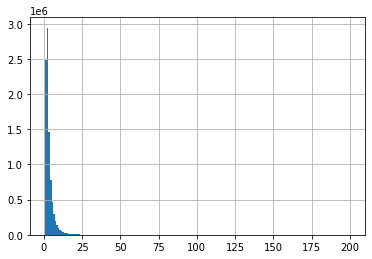

In [15]:
print(f"number of unique sessions: {len(df['session_id:token'].unique())}")
sess_lengths = df['session_id:token'].value_counts()
sess_lengths.hist(bins=200)

In [18]:
# check how many sessions we have in each length 
# output is: (length , # of sessions)
sess_lengths.value_counts(sort=False)

200          6
199          7
198          3
195          5
194          1
        ...   
5       473054
4       785870
3      1463174
2      2945317
1      2493154
Name: session_id:token, Length: 190, dtype: int64

we have total of 9249729 sessions, of which 2493154 are of length 1, if we ignore them (as done in the various papers) we're left with 6756575 sessions

#### item & user statistics

In [19]:
print(f"number of unique items: {len(df['item_id:token'].unique())}")

number of unique items: 52739


In [22]:
item_cnts = df['item_id:token'].value_counts()
item_cnts

214853094    102215
214829878     99509
643078800     76329
214853420     63407
214853096     55772
              ...  
214645440         1
214548120         1
214547807         1
214811304         1
214687078         1
Name: item_id:token, Length: 52739, dtype: int64

In [24]:
# check how many items have X occurences
# output is: (X occurences , # of items)
# for example : 6970 items occured only once, 4214 occured twice etc.
item_cnts.value_counts(sort=False)

102215       1
99509        1
76329        1
63407        1
55772        1
          ... 
5         1628
4         2151
3         2838
2         4214
1         6970
Name: item_id:token, Length: 4350, dtype: int64

## reading through RecBole Framework

# RetailRocket

## `.inter` files

In [26]:
dataset_path = os.path.expanduser('~/local/datasets/recsys/recbole/RecBole/ProcessedDatasets/Retailrocket/merged')
print(dataset_path)
[f for f in os.listdir(dataset_path) if f.endswith('.inter')]

/nfs/iil/home/gkoren2/local/datasets/recsys/recbole/RecBole/ProcessedDatasets/Retailrocket/merged


['retailrocket-addtocart.inter',
 'retailrocket-view.inter',
 'retailrocket-transaction.inter']

In [27]:
!cat {os.path.join(dataset_path,'README.md')}

VIEW INTERACTIONs DATASET FILE DESCRIPTION
------------------------------------------------------------------------------------
------------------------------------------------------------------------------------
The file retailrocket-view.inter comprising the view records of users.
Each record/line in the file has the following fields: timestamp, visitor_id, item_id, count

timestamp: the time when the view occurred, and its type is float.
visitor_id: the id of the visitor, and its type is token.
item_id: the id of the item, and its type is token.
count: the number of the event, and its type is float.

ADDTOCART INTERACTIONs DATASET FILE DESCRIPTION
------------------------------------------------------------------------------------
------------------------------------------------------------------------------------
The file retailrocket-addtocart.inter comprising the addtocart records of users.
Each record/line in the file has the following fields: timestamp, visitor_id, item_id, cou

In [29]:
df=pd.read_csv(os.path.join(dataset_path,'retailrocket-view.inter'),sep='\t')
df.head()

,timestamp:float,visitor_id:token,item_id:token,count:float
0,1433221332117,257597,355908,1
1,1433224214164,992329,248676,1
2,1433221999827,111016,318965,2
3,1433221955914,483717,253185,2
4,1433221337106,951259,367447,1


In [30]:
len(df['visitor_id:token'].unique()) 

1404179

In [33]:
item_cnts=df['item_id:token'].value_counts()
item_cnts

187946    2911
5411      2078
370653    1577
461686    1379
96924     1359
          ... 
306737       1
129845       1
57928        1
443836       1
177353       1
Name: item_id:token, Length: 234838, dtype: int64

In [35]:
item_cnts.value_counts(sort=False)

2911        1
2078        1
1577        1
1379        1
1359        1
        ...  
5       10476
4       14447
3       21182
2       36200
1       81374
Name: item_id:token, Length: 477, dtype: int64